In [1]:
from Populations import *
from PhagePopulation import *
import matplotlib.pyplot as plt
import numpy as np
import itertools as itTools
import math
import time

In [38]:
class Instance():
    def __init__(self, initialHostPopulationValues, initialPhagePopulationValues, carryingCap, fitnessParameters, lysisQuantities, hostMutMatrix, infectionMatrix, phageMutMatrix, numIters):
        self.hostPopulations = []
        self.phagePopulations = []
        self.carryingCapacity = carryingCap
        self.numIterations = numIters
        self.maximumTimeResolution = 0.01
        
        self.initializePopulations(initialHostPopulationValues, initialPhagePopulationValues, fitnessParameters, lysisQuantities)

        self.timeValues = np.zeros(numIters + 1)
        
        self.hostPopulationValues = np.zeros((len(self.hostPopulations), numIters + 1))
        self.hostPopulationValues[:, 0] = [self.hostPopulations[k].populationLevel for k in range(len(self.hostPopulations))]
        
        self.phagePopulationValues = np.zeros((len(self.phagePopulations), numIters + 1))
        self.phagePopulationValues[:, 0] = [self.phagePopulations[k].populationLevel for k in range(len(self.phagePopulations))]

        self.hostMutationMatrix = hostMutMatrix
        self.phageHostInfectionMatrix = infectionMatrix
        self.phageMutationMatrix = phageMutMatrix
        self.completedRun = False

    def initializePopulations(self, initialHostPopVals, initialPhagePopVals, fitnessParams, lysisQuantities):
        for j in range(len(fitnessParams)):
            self.hostPopulations.append(hostPopulation(j, initialHostPopVals[j], fitnessParams[j]))

        hostPopVals = [pop.populationLevel for pop in self.hostPopulations]
        for pop in self.hostPopulations:
            pop.computeGrowthRate(hostPopVals, self.carryingCapacity)
            pop.regenerateTimer()
            
        for j in range(len(initialPhagePopVals)):
            self.phagePopulations.append(phagePopulation(j, initialPhagePopVals[j], lysisQuantities[0], lysisQuantities[1]))


    def runAlgorithm(self):
        for k in range(self.numIterations):
            #Step 1
            (update, minTimer, virocell, minPopIdx) = self.findMinPopTimer()
            
            #Step 2
            self.timeValues[k + 1] = self.timeValues[k] + minTimer
            
            #Step 3

            if update:
                if not virocell:
                    self.updateHostPopulation(minPopIdx)
                else:
                    self.updatePhagePopulation(minPopIdx)
            
            self.hostPopulationValues[:, k + 1] = [self.hostPopulations[k].populationLevel for k in range(len(self.hostPopulations))]

            #ChatGPT is nice: really, really try debugging yourself first though!
            self.phagePopulationValues[:, k + 1] = [self.phagePopulations[k].populationLevel for k in range(len(self.phagePopulations))]
    
            #Step 4
            self.recomputeGrowthRates()
    
            #Step 5
            self.updateHostTimers(minTimer)
            self.updatePhageTimers(minTimer)
    
            #Step 6
            self.regeneratePopTimers()

        self.completedRun = True
    
    def findMinPopTimer(self):
        hostPopTimers = [pop.getTimer() for pop in self.hostPopulations]
        phagePopTimers = [pop.getTimer() for pop in self.phagePopulations]
        minHostTimer = min(hostPopTimers)
        minPhageTimer = min(phagePopTimers)
        
        minHostPopTimerIdx = hostPopTimers.index(minHostTimer)
        minPhagePopTimerIdx = phagePopTimers.index(minPhageTimer)

        virocell = minHostTimer > minPhageTimer
        if not virocell:
            minTimer = minHostTimer
            minPopTimerIdx = minHostPopTimerIdx
        else:
            minTimer = minPhageTimer
            minPopTimerIdx = minPhagePopTimerIdx

        if minTimer > self.maximumTimeResolution:
            toUpdateOrNotToUpdate = False
            minTimer = self.maximumTimeResolution
        else:
            toUpdateOrNotToUpdate = True
            
        return (toUpdateOrNotToUpdate, minTimer, virocell, minPopTimerIdx)

    def updateHostPopulation(self, minPopIdx):
        #Get the growth rate's sign to see growth or death
        growth_rate = self.hostPopulations[minPopIdx].growthRate
        
        if growth_rate > 0:
            localMutationProbabilities = self.hostMutationMatrix[minPopIdx, :]
            possibilities = [n for n in range(len(self.hostPopulations))]
            #random.choice(what you're choosing from, how many you're choosing, are you replacing, weights)
            spawnChoiceIdx = np.random.choice(possibilities, None, True, localMutationProbabilities)
            self.hostPopulations[spawnChoiceIdx].changePopulation(1)
        elif growth_rate < 0:
            self.hostPopulations[minPopIdx].changePopulation(-1)
        else:
            self.hostPopulations[minPopIdx].changePopulation(0)

    def everyHostIsNotInfectedProb(self, infectionProb, numHosts):
        return (1 - infectionProb)**numHosts

    def infectionDistribution(self, hostPopulations, viralType):
        totalPops = np.sum(hostPopulations)
    
        if totalPops == 0:
            return [0 for k in range(len(hostPopulations))]
        
        normalizedHostPops = hostPopulations / totalPops
        nonzeroPops = [numPops for numPops in normalizedHostPops if numPops != 0]
    
        #This tuple contains what population types are not at zero
        nonzeroPopulationIndices = np.nonzero(hostPopulations)
        print("\nExtant Host Types: {}".format(nonzeroPopulationIndices[0]))
        
        
        print("\nPop Fracs = {}".format(nonzeroPops))
        m = len(nonzeroPops)
        nonzeroHostTypes = nonzeroPopulationIndices[0]
        
        #These probabilities are just designed as tests to give each coin a different probability without any of them being 1 or 0
        infectionProbabilities = self.phageHostInfectionMatrix[viralType]
        #print("\nHeads Probabilities: {}".format(infectionProbabilities))
        amalgamatedInfectionProbabilities = [1 - self.everyHostIsNotInfectedProb(infectionProbabilities[k], hostPopulations[k]) for k in range(len(hostPopulations))]
        #print("\nAmalgamated Heads Probabilities: {}".format(amalgamatedInfectionProbabilities))
        nonInfectionProbabilities = [1 - amalgamatedInfectionProbabilities[k] for k in range(len(hostPopulations))]
        #print("\nTails Probabilities: {}".format(nonInfectionProbabilities))
        typeISelectionProb = [0 for k in range(len(hostPopulations))]
        for i in range(m):
            typeJ = nonzeroHostTypes[i]
            #print(typeJ)
            probThatN_0EqualToNConditionedTypeIsJ = [0 for k in range(m)]
            for n in range(m):
                r = n
                permutations = itTools.permutations([index for index in nonzeroHostTypes if index != typeJ], r)
                #In the model's case, r = n - 1
                sum = 0
                startLoop = time.process_time()
                for permutation in permutations:
                    #print("\nPermutation = {}".format(permutation))
                    permutationTailProbs = [nonInfectionProbabilities[permutationIdx] for permutationIdx in permutation]
                    #print("Associated Tails Probabilities = {}".format(permutationTailProbs))
                    if (r == 0):
                        product = math.factorial(m - 1)
                    else:
                        product = np.prod(permutationTailProbs)
                    #This function actually returns 1 for an empty permutation list, so that actually works really well for n_0 = 1! But why does it do this?
                    #Actually, that's the problem! It actually needs to return (m-1)! (i.e. 1 for each permutation of all the back elements that aren't actually effecting when the heads shows up)
                    sum += product
                endLoop = time.process_time()
                #print("Final Sum of Permutation Products = {}".format(sum))
                #print("Time Taken: {} ms\n".format(endLoop - startLoop))
                probThatN_0EqualToNConditionedTypeIsJ[n] = (amalgamatedInfectionProbabilities[typeJ] / math.factorial(m - 1)) * sum
                #print(probThatN_0EqualToNConditionedTypeIsJ)
            
            overallProb = np.sum(probThatN_0EqualToNConditionedTypeIsJ) / m
            #print("\nProbability that the first infection occurs at type {} is {}".format(typeJ, overallProb))
            typeISelectionProb[i] = overallProb
        #print(typeISelectionProb)
        #print("Sum of the Probabilities for each type: {}".format(np.sum(typeISelectionProb)))
    
        #We need to make sure that the returned infection distribution also includes 0 for those populations which were nonexistent and excised from the algorithm
        infectionDist = [0 for k in range(len(hostPopulations))]
        numNonzeroPopulationsObserved = 0
        for k in range(len(hostPopulations)):
            if hostPopulations[k] == 0:
                infectionDist[k] = 0
            else:
                infectionDist[k] = typeISelectionProb[numNonzeroPopulationsObserved]
                numNonzeroPopulationsObserved += 1
            
        return infectionDist
    
    def fracHostsInfectedOnce(self, numHosts, numInfectingPhage):
        #[(hosts - 1)/ hosts]^phage)
        if (numHosts == 0):
            return 0
        else:
            return 1 - ((numHosts - 1) / numHosts)**numInfectingPhage

    def getInfectionDistrus(self):
        numPhage = len(self.phagePopulations)
        infectionDistrus = [self.infectionDistribution([pop.populationLevel for pop in self.hostPopulations], j) for j in range(numPhage)]

        return infectionDistrus
    
    def getNewInfections(self, newParticles, infectionDistrus, hostIndex):
        #Summing up the product between the new particles of a given viral type and the fraction of those new particles
        #that will infect this particular host
        hostPopLevel = self.hostPopulations[hostIndex].populationLevel
        
        newInfections = [round(newParticles[j] * infectionDistrus[j][hostIndex]) for j in range(len(infectionDistrus))]
        return newInfections
    
    def updatePhagePopulation(self, minPopIdx):
        numCorrespondingVirocells = self.phagePopulations[minPopIdx].populationLevel
        newPhageParticles = self.phagePopulations[minPopIdx].burstSize * numCorrespondingVirocells
        
        totalHostNum = sum([pop.populationLevel for pop in self.hostPopulations])

        mutationProbabilities = self.phageMutationMatrix[minPopIdx, :]
        phageOfDifferingTypes = [newPhageParticles * mutationProbabilities[k] for k in range(len(self.hostPopulations))]
        
        infectionDistrus = self.getInfectionDistrus()
        
        #print("Computed Infection Distributions: {}".format(infectionDistrus))
        
        newInfections = [self.getNewInfections(phageOfDifferingTypes, infectionDistrus, k) for k in range(len(self.hostPopulations))]
        
        print("New Infections Received: {}".format(newInfections))
        self.phagePopulations[minPopIdx].populationLevel = 0

        for j in range(len(self.hostPopulations)):
            numPhage = len(self.phagePopulations)
            startingHostJPopLevel = self.hostPopulations[j].populationLevel
            fracsOfTypeJInfected = [self.fracHostsInfectedOnce(startingHostJPopLevel, newInfections[k][j]) for k in range(numPhage)]
            fracOfTypeJInfected = sum(fracsOfTypeJInfected)
            print("Frac of Type {} Infected: {}".format(j, fracOfTypeJInfected))
            hostsOfTypeJInfected = np.ceil(startingHostJPopLevel * fracOfTypeJInfected)
            print("Num Hosts of Type {} Infected: {}".format(j, hostsOfTypeJInfected))
            self.hostPopulations[j].changePopulation(-hostsOfTypeJInfected)

            #This actually updates based on the number of new unique infections, which is the number of new virocells
            for k in range(numPhage):
                numHostJInfectedByPhageK = np.ceil(startingHostJPopLevel * fracsOfTypeJInfected[k])
                self.phagePopulations[k].changePopulation(numHostJInfectedByPhageK)
            #Extinction is extinction: no negative abundances.
    
    def recomputeGrowthRates(self):
        hostPopVals = [pop.populationLevel for pop in self.hostPopulations]
        for pop in self.hostPopulations:
            pop.computeGrowthRate(hostPopVals, self.carryingCapacity)

    def updateHostTimers(self, minPopTimer):
        for pop in self.hostPopulations:
            pop.updateTimer(minPopTimer)

    def updatePhageTimers(self, minPopTimer):
        for pop in self.phagePopulations:
            pop.updateTimer(minPopTimer)

    def regeneratePopTimers(self):
        for pop in self.hostPopulations:
            pop.regenerateTimer()

        for pop in self.phagePopulations:
            pop.regenerateTimer()
    
    def allPopsReportForDuty(self):
        for j in range(len(self.hostPopulations)):
            self.hostPopulations[j].reportPopInfo()

        for j in range(len(self.phagePopulations)):
            self.phagePopulations[j].reportPopInfo()

    def displayResultsAsTimecourses(self):
        if (self.completedRun == False):
            print("\nYou need to generate some data first!\n")
        else:
            for j in range(len(self.hostPopulations)):
                plt.plot(self.timeValues, self.hostPopulationValues[j, :])


Information for Host Population 0
-----------------------------
Population Level: 30000
Fitness Parameter: 0.5
Would-be Exponential Growth Rate: 15000.0
Logistic Growth Rate: 7485.0
Timer Value: 0.00013289216768660862

Information for Host Population 1
-----------------------------
Population Level: 20000
Fitness Parameter: 0.5
Would-be Exponential Growth Rate: 10000.0
Logistic Growth Rate: 4990.0
Timer Value: 7.718571936800081e-05

Information for Host Population 2
-----------------------------
Population Level: 100
Fitness Parameter: 0.5
Would-be Exponential Growth Rate: 50.0
Logistic Growth Rate: 24.95
Timer Value: 0.09866079261711112

Information for Phage Population 0
-----------------------------
Population Level: 1
Burst Size: 2
Lysis Time: 10
Timer Value: 9.001

Information for Phage Population 1
-----------------------------
Population Level: 0
Burst Size: 2
Lysis Time: 10
Timer Value: inf

Information for Phage Population 2
-----------------------------
Population Level: 0
B

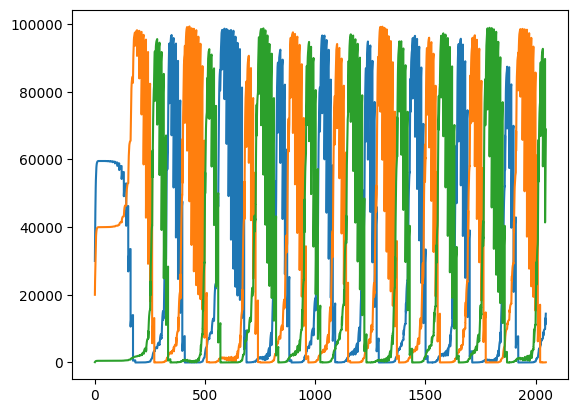

In [54]:
hostMutationMatrix = np.zeros((3, 3))
hostMutationMatrix[0, 0] = 0.99
hostMutationMatrix[0, 1] = 0.01
hostMutationMatrix[0, 2] = 0
hostMutationMatrix[1, 0] = 0
hostMutationMatrix[1, 1] = 0.99
hostMutationMatrix[1, 2] = 0.01
hostMutationMatrix[2, 0] = 0.01
hostMutationMatrix[2, 1] = 0
hostMutationMatrix[2, 2] = 0.99

infectionMatrix = np.zeros((3, 3))
infectionMatrix[0, 0] = 1
infectionMatrix[0, 1] = 0
infectionMatrix[0, 2] = 0
infectionMatrix[1, 0] = 0
infectionMatrix[1, 1] = 1
infectionMatrix[1, 2] = 0
infectionMatrix[2, 0] = 0
infectionMatrix[2, 1] = 0
infectionMatrix[2, 2] = 1

phageMutationMatrix = np.zeros((3, 3))
phageMutationMatrix[0, 0] = 0.999
phageMutationMatrix[0, 1] = 0.001
phageMutationMatrix[0, 2] = 0
phageMutationMatrix[1, 0] = 0
phageMutationMatrix[1, 1] = 0.999
phageMutationMatrix[1, 2] = 0.001
phageMutationMatrix[2, 0] = 0.001
phageMutationMatrix[2, 1] = 0
phageMutationMatrix[2, 2] = 0.999

burstSize = 2
lysisTime = 10

newInst = Instance([30000, 20000, 100], [1, 0, 0], 100000, [0.5, 0.5, 0.5], [burstSize, lysisTime], hostMutationMatrix, infectionMatrix, phageMutationMatrix, 9600000)

newInst.allPopsReportForDuty()

print("\nTesting findMinPopTimer()\n")
print(newInst.findMinPopTimer())

print("\nTesting updateHostPopulation()\n")
newInst.updateHostPopulation(0)

newInst.allPopsReportForDuty()

print("\nTesting runAlgorithm()\n")
newInst.runAlgorithm()

newInst.allPopsReportForDuty()

print("\nTesting displayResultsAsTimecourses()\n")
newInst.displayResultsAsTimecourses()

print(newInst.timeValues)